# Imports


In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold

# Functions

In [73]:
def find_upper_outliers(dataframe, column_name):
    c_name = dataframe[column_name]
    mean = np.mean(c_name)
    std = np.std(c_name)
    outliers = [i for i in c_name if i > mean + (3 * std)]
    outliers.sort()
    print("How many outliers are there: " + str(len(outliers)))
    print(outliers[:10])
    return outliers

def find_lower_outliers(dataframe, column_name):
    c_name = dataframe[column_name]
    mean = np.mean(c_name)
    std = np.std(c_name)
    outliers = [i for i in c_name if i < mean - (3 * std)]
    outliers.sort()
    print("How many outliers are there: " + str(len(outliers)))
    print(outliers[:10])
    return outliers
def variance_threshold_selector(data, thresh=0.0):
    selector = VarianceThreshold(threshold=thresh)
    selector.fit(data)
    return [column for column in data.columns if not selector.get_support()[data.columns.get_loc(column)]] 
def detect_upper_outliers_with_IQR(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    upper_bound = q3 + (1.5 * iqr)
    outliers = [x for x in data if x > upper_bound]
    return outliers
def detect_lower_outliers_with_IQR(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    outliers = [x for x in data if x < lower_bound]
    return outliers    
       

# Data Cleansing and Data Transformation


## First Data Frame

In [74]:
# First Dataframe is bank_df
bank_df = pd.read_csv('bank.csv', sep=';')

In [75]:
bank_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [76]:
bank_df.shape

(4521, 17)

In [77]:
print(f'Any NaN values? {bank_df.isna().values.any()}')

Any NaN values? False


In [78]:
print(f'Any duplicates? {bank_df.duplicated().values.any()}')

Any duplicates? False



There are no Nan values or duplicates in the bank dataframe. Let's check for outliers.





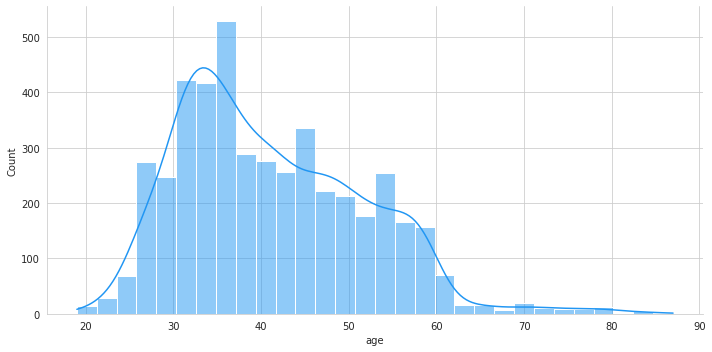

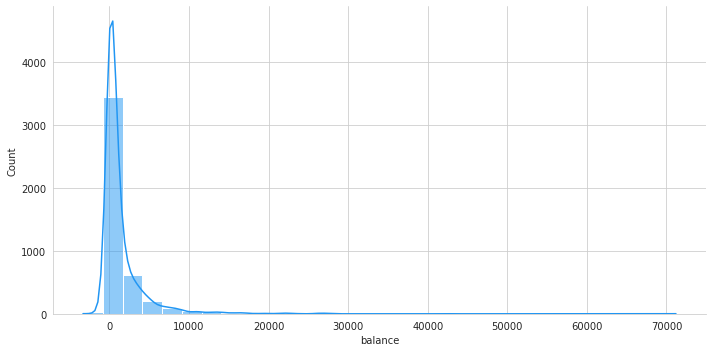

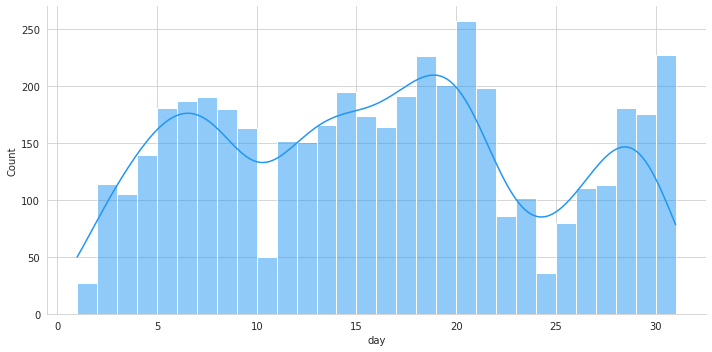

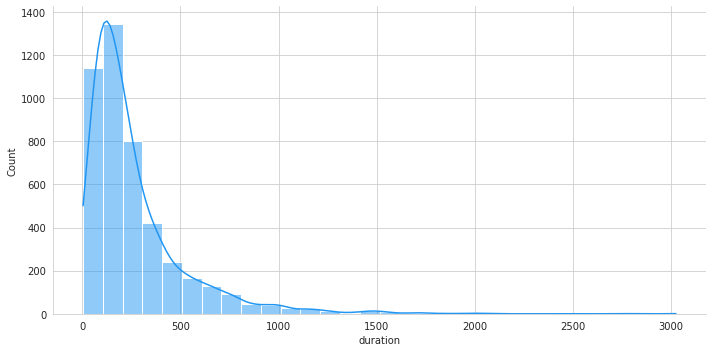

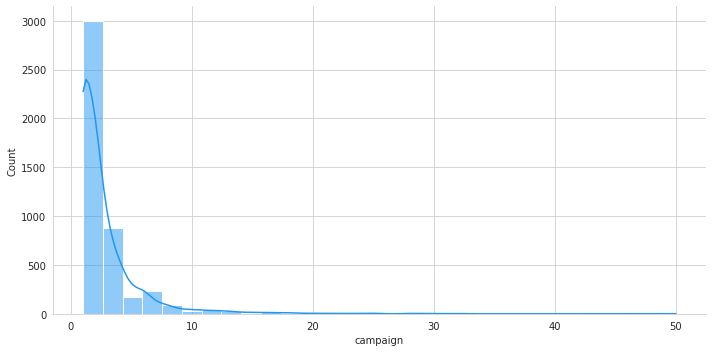

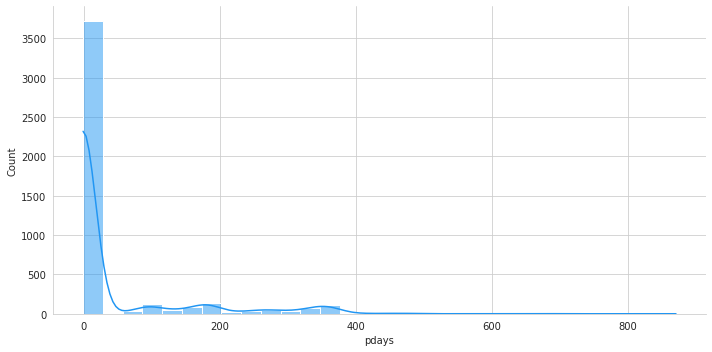

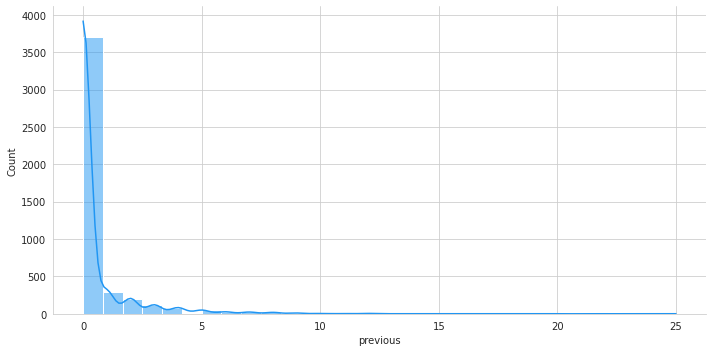

In [79]:
# Numerical Columns: 'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'
numerical_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

for col_name in numerical_cols:
  sns.displot(data=bank_df,
              bins=30,
              x=col_name, 
              aspect=2,
              kde=True, 
              color='#2196f3')


Let's check lower outliers

In [80]:
for col_name in numerical_cols:
  outliers = find_lower_outliers(bank_df, col_name)

How many outliers are there: 0
[]
How many outliers are there: 0
[]
How many outliers are there: 0
[]
How many outliers are there: 0
[]
How many outliers are there: 0
[]
How many outliers are there: 0
[]
How many outliers are there: 0
[]


There are no lower outliers. Let's check upper outliers

In [81]:
for col_name in numerical_cols:
  print(col_name)
  outliers = find_upper_outliers(bank_df, col_name)


age
How many outliers are there: 44
[73, 73, 73, 73, 73, 73, 74, 74, 74, 75]
balance
How many outliers are there: 88
[10655, 10758, 10786, 10787, 10788, 10888, 10907, 10910, 10924, 11084]
day
How many outliers are there: 0
[]
duration
How many outliers are there: 88
[1044, 1056, 1060, 1063, 1065, 1073, 1081, 1083, 1088, 1097]
campaign
How many outliers are there: 87
[13, 13, 13, 13, 13, 13, 13, 13, 13, 13]
pdays
How many outliers are there: 171
[341, 342, 342, 342, 342, 342, 342, 343, 343, 343]
previous
How many outliers are there: 99
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6]


Only the day column does not have upper outliers. 

In [82]:
# pdays: Because it contains a categorical value, first remove the -1 value, which indicates that the consumer has never been contacted before, and then look for any upper outliers.
temp_df = bank_df[bank_df['pdays'] > 0]
outliers_pdays = find_upper_outliers(temp_df, 'pdays')

How many outliers are there: 7
[674, 683, 687, 761, 804, 808, 871]


## Handling Outliers

In [83]:
# for age and duration columns apply logorithmic transformation
# drop outliers from balance column
# campaign: drop outliers
# pdays: drop outliers
# previous: drop outliers

In [84]:
# Logarithmic Transformation for age and duration columns
bank_df['log_age'] = np.log(bank_df['age'])
bank_df['log_duration'] = np.log(bank_df['duration'])

In [85]:
bank_df.drop(columns=['age', 'duration'], inplace=True, axis=1)

In [86]:
# dropping outliers from balance column
bank_df = bank_df[bank_df['balance'] < 10655]
bank_df.shape

(4433, 17)

In [87]:
#campaign: drop outliers
bank_df = bank_df[bank_df['campaign'] < 13]
bank_df.shape

(4349, 17)

In [88]:
# pdays: drop outliers
bank_df = bank_df[bank_df['pdays'] < 674]
bank_df.shape

(4342, 17)

In [89]:
#previous: drop outliers
bank_df = bank_df[bank_df['previous'] < 6]
bank_df.shape

(4248, 17)

## Feature Selection

In [90]:
dataset = bank_df.drop(columns=['log_age','balance', 'day', 'log_duration', 'campaign',
       'pdays', 'previous'])

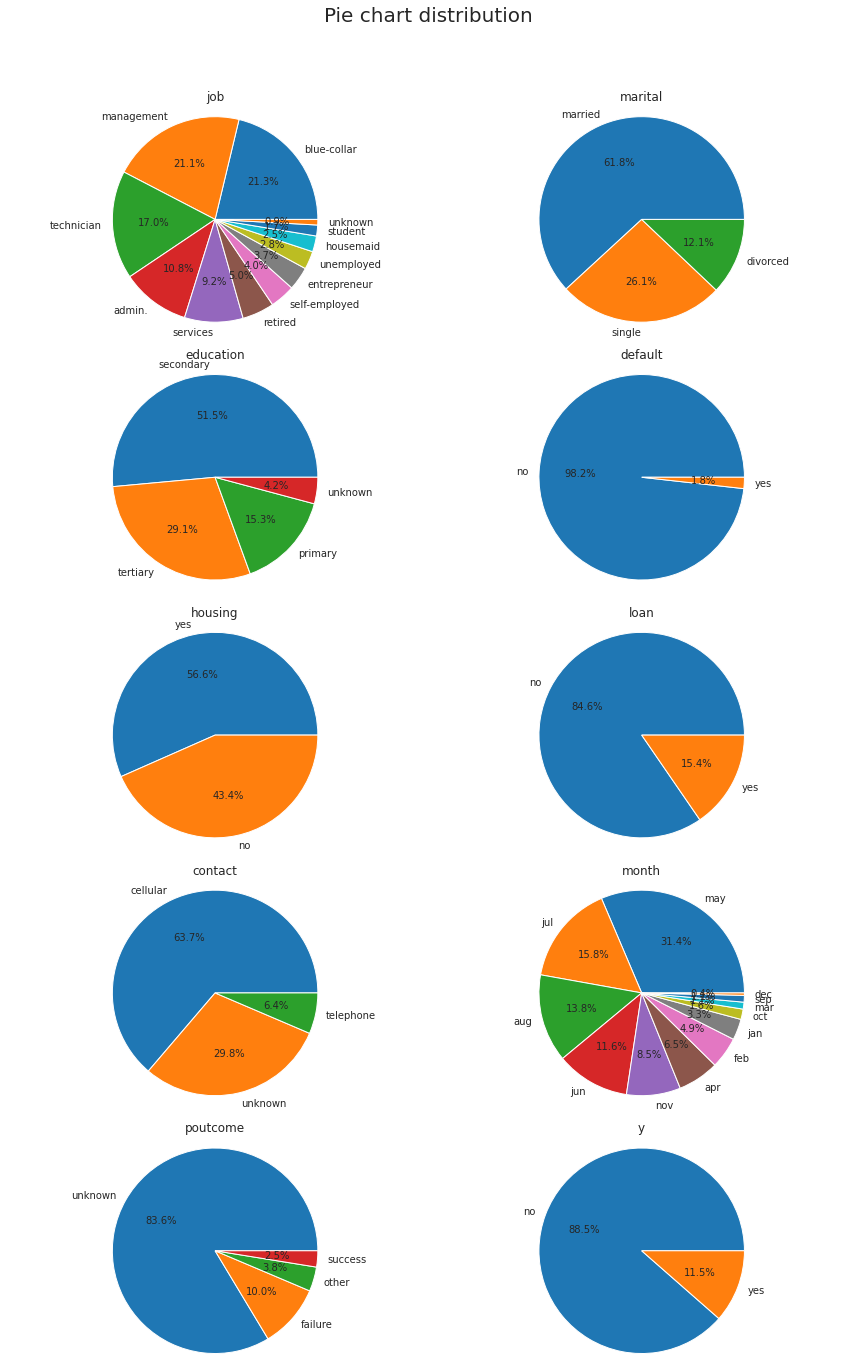

In [91]:
fig = plt.figure(figsize=(12,20))
plt.suptitle('Pie chart distribution', fontsize=20)

for i in range(1, dataset.shape[1]+1):
    plt.subplot(5,2,i)
    f=plt.gca()
    f.axes.get_yaxis().set_visible(False)
    f.set_title(dataset.columns.values[i-1])
    
    values = dataset.iloc[:,i-1].value_counts(normalize = True).values
    index = dataset.iloc[:,i-1].value_counts(normalize = True).index
    
    plt.pie(values, labels=index, autopct='%1.1f%%')
    plt.axis('equal')

plt.tight_layout(rect=[0,0.03,1,0.95])

### Transformation of Categorical Variables

In [92]:
bank_df['y'].replace(['no', 'yes'], [0, 1], inplace=True)

In [93]:
#identify all categorical variables
cat_columns = bank_df.select_dtypes(['object']).columns

#convert all categorical variables to numeric
bank_df[cat_columns] = bank_df[cat_columns].apply(lambda x: pd.factorize(x)[0])

### Important Features

In [94]:
target = bank_df['y']
features = bank_df.drop('y', axis=1)

# train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=None)
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.2, 
                                                      random_state=10, shuffle=True, stratify=None)

# train random forest regressor
rf = RandomForestRegressor(n_estimators = 1000)
rf.fit(X_train, y_train)

# Perform feature selection with feature names
selector = SelectFromModel(rf, threshold='mean', prefit=True, max_features=5, importance_getter=lambda x: x.feature_importances_)
X_train_new = selector.transform(X_train.values)
X_test_new = selector.transform(X_test.values)

# Get selected feature names
selected_feature_names = [features.columns[i] for i in selector.get_support(indices=True)]

# Print selected feature names and indices
print('Selected feature names:', selected_feature_names)
print('Selected feature indices:', selector.get_support(indices=True))


Selected feature names: ['balance', 'day', 'poutcome', 'log_age', 'log_duration']
Selected feature indices: [ 4  8 13 14 15]


In [95]:
# Feature Selection with Recursive feature elimination (RFE)

lr = LogisticRegression(max_iter=10000)

# Perform RFE to select the top 10 features
rfe = RFE(estimator=lr, n_features_to_select=5, step=1)
rfe.fit(X_train, y_train)

# Print the feature ranking
print("Feature ranking:", rfe.ranking_)

# Get selected feature names
selected_feature_names = [features.columns[i] for i in selector.get_support(indices=True)]

# Print the indices of the selected features
print('Selected feature names:', selected_feature_names)
print("Selected features:", rfe.get_support(indices=True))

Feature ranking: [ 6  4  5  1 12  1  1  2  9 10  8 11  7  1  3  1]
Selected feature names: ['balance', 'day', 'poutcome', 'log_age', 'log_duration']
Selected features: [ 3  5  6 13 15]


In [96]:
feature_ranking = [ 5,  2,  4,  1, 12,  1,  1,  3, 11, 10,  7,  9,  6,  1,  8,  1]
len(feature_ranking)

16

In [97]:
X_train.columns

Index(['job', 'marital', 'education', 'default', 'balance', 'housing', 'loan',
       'contact', 'day', 'month', 'campaign', 'pdays', 'previous', 'poutcome',
       'log_age', 'log_duration'],
      dtype='object')

In [98]:
# Rankings with 1: default, housing, loan, poutcome, log_duration


In [99]:
column_names = ['job', 'marital', 'education', 'default', 'balance', 'housing', 'loan','contact', 'day', 'month', 'campaign', 'pdays', 'previous', 'poutcome', 'log_age', 'log_duration']

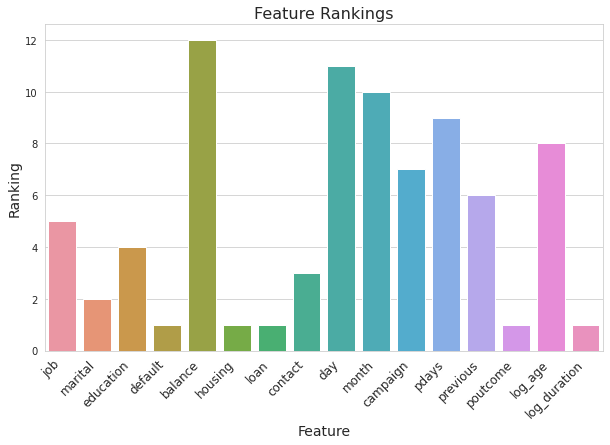

In [100]:
# create a pandas dataframe
df = pd.DataFrame({'feature_ranking': feature_ranking, 'column_names': column_names})
# plot a bar graph using seaborn
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
ax = sns.barplot(x="column_names", y="feature_ranking", data=df)
ax.set_xticklabels(column_names, rotation=45, ha='right', fontsize=12)
ax.set_xlabel('Feature', fontsize=14)
ax.set_ylabel('Ranking', fontsize=14)
ax.set_title('Feature Rankings', fontsize=16)
plt.show()

In [101]:
remove_col = variance_threshold_selector(X_train, thresh=0.05)
remove_col

['default']

In [102]:
bank_df.head()

,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y,log_age,log_duration
0,0,0,0,0,1787,0,0,0,19,0,1,-1,0,0,0,3.401197,4.369448
1,1,0,1,0,4789,1,1,0,11,1,1,339,4,1,0,3.496508,5.393628
2,2,1,2,0,1350,1,0,0,16,2,1,330,1,1,0,3.555348,5.220356
3,2,0,2,0,1476,1,1,1,3,3,4,-1,0,0,0,3.401197,5.293305
4,3,0,1,0,0,1,0,1,5,1,1,-1,0,0,0,4.077537,5.420535


In [103]:
bank_df.shape

(4248, 17)

In [104]:
bank_df['y'].value_counts()

0    3761
1     487
Name: y, dtype: int64

## Save the clean dataframe

In [105]:
bank_df.to_csv('bank_clean.csv', sep=";", index=False)

In [106]:
bank_df.drop(columns=['default'], inplace=True, axis=1)

In [107]:
bank_df.to_csv('bank_clean16_without_default.csv', sep=";", index=False)

In [108]:
bank_df.drop(columns=['log_duration'], inplace=True, axis=1)

In [109]:
bank_df.to_csv('bank_clean15_without_duration.csv', sep=";", index=False)

<hr/>

<hr/>


## Second Data Frame

In [110]:
# Second Dataframe is bank_df
bank_full_df = pd.read_csv('/content/bank-full.csv', sep=';')

In [111]:
bank_full_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [112]:
bank_full_df.shape

(45211, 17)

In [113]:
print(f'Any NaN values? {bank_full_df.isna().values.any()}')
print(f'Any duplicates? {bank_full_df.duplicated().values.any()}')

Any NaN values? False
Any duplicates? False


There are no Nan values or duplicate rows in bank full dataframe. Let's check for outliers.

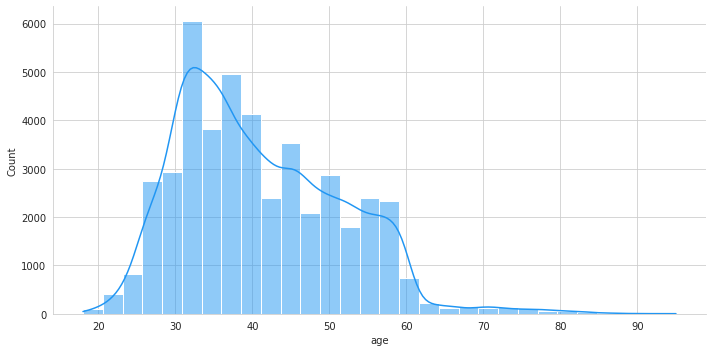

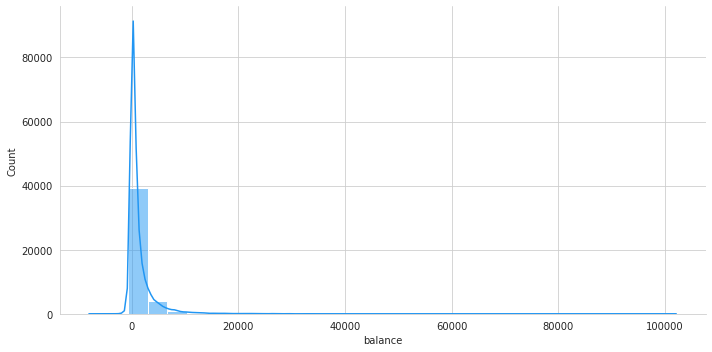

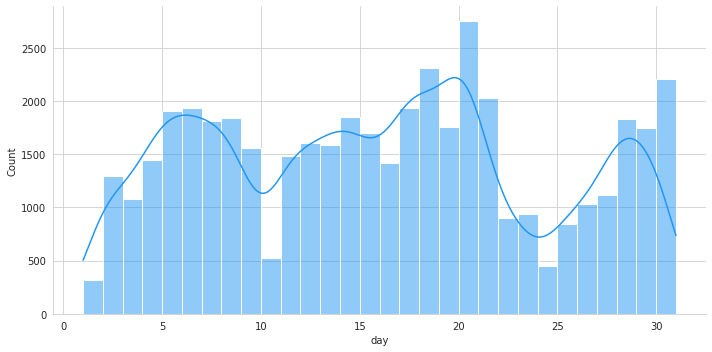

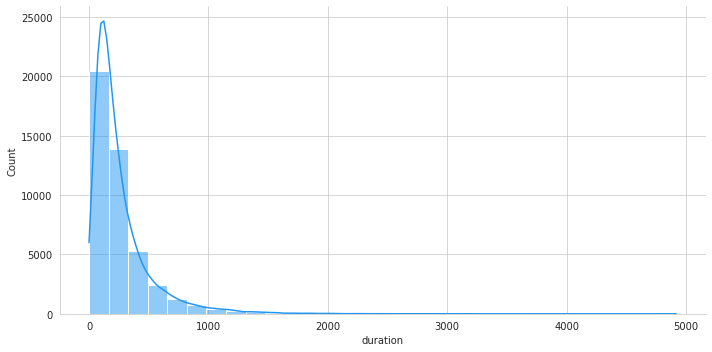

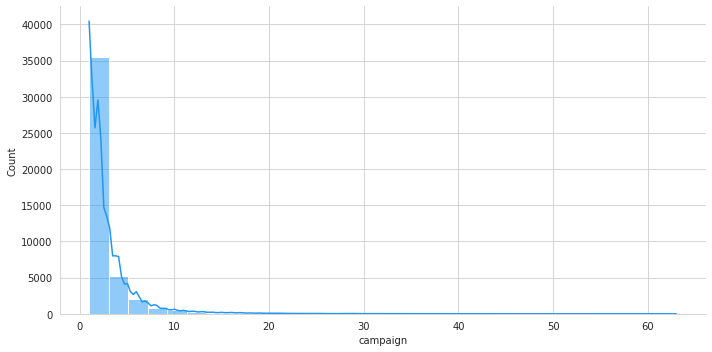

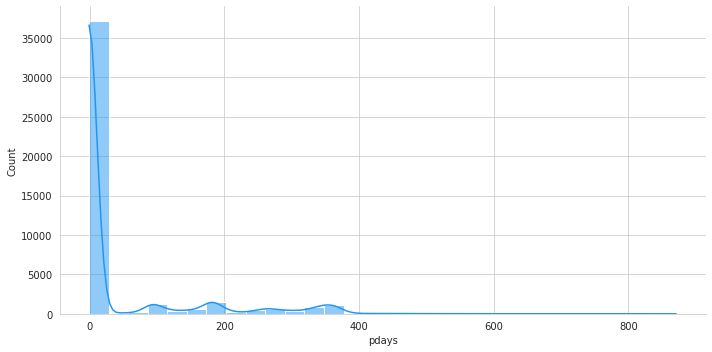

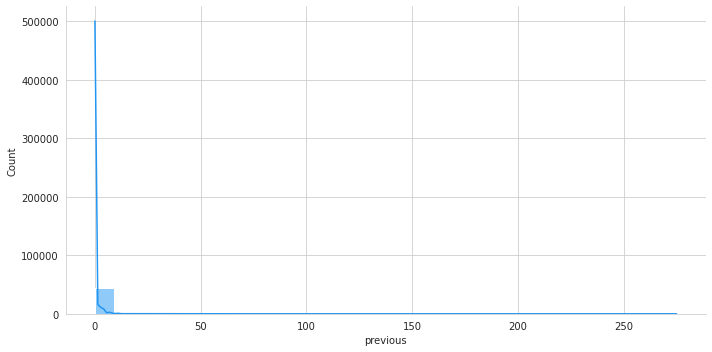

In [114]:
for col_name in numerical_cols:
  sns.displot(data=bank_full_df,
              bins=30,
              x=col_name, 
              aspect=2,
              kde=True, 
              color='#2196f3')

Let's check lower outliers

In [115]:
for col_name in numerical_cols:
  print(col_name)
  outliers = find_lower_outliers(bank_full_df, col_name)

age
How many outliers are there: 0
[]
balance
How many outliers are there: 1
[-8019]
day
How many outliers are there: 0
[]
duration
How many outliers are there: 0
[]
campaign
How many outliers are there: 0
[]
pdays
How many outliers are there: 0
[]
previous
How many outliers are there: 0
[]


In [116]:
bank_full_df['balance'].idxmin()

12909

In [117]:
bank_full_df.loc[12909]

age                   26
job          blue-collar
marital           single
education      secondary
default              yes
balance            -8019
housing               no
loan                 yes
contact         cellular
day                    7
month                jul
duration             299
campaign               3
pdays                 -1
previous               0
poutcome         unknown
y                     no
Name: 12909, dtype: object

Let's drop lower outlier from balance feature

In [118]:
bank_full_df = bank_full_df.drop(index=12909)

Now there are no lower outliers in the full bank dataframe except one in balance. Let's check for upper outliers.

In [119]:
for col_name in numerical_cols:
  print(col_name)
  outliers = find_upper_outliers(bank_full_df, col_name)

age
How many outliers are there: 381
[73, 73, 73, 73, 73, 73, 73, 73, 73, 73]
balance
How many outliers are there: 744
[10500, 10532, 10536, 10541, 10541, 10558, 10561, 10576, 10583, 10583]
day
How many outliers are there: 0
[]
duration
How many outliers are there: 963
[1031, 1031, 1032, 1032, 1032, 1032, 1032, 1032, 1032, 1033]
campaign
How many outliers are there: 840
[13, 13, 13, 13, 13, 13, 13, 13, 13, 13]
pdays
How many outliers are there: 1723
[341, 341, 341, 341, 341, 341, 341, 341, 341, 341]
previous
How many outliers are there: 582
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8]


In [120]:
# pdays: Because it contains a categorical value, first remove the -1 value, which indicates that the consumer has never been contacted before, and then look for any upper outliers.
temp_df = bank_full_df[bank_full_df['pdays'] > 0]
outliers_pdays = find_upper_outliers(temp_df, 'pdays')

How many outliers are there: 61
[578, 579, 585, 586, 587, 589, 592, 594, 595, 603]


## Handling Outliers for Full Bank Data Frame

In [121]:
# for age and duration columns apply logorithmic transformation
# drop outliers from balance column
# campaign: drop outliers
# pdays: drop outliers
# previous: drop outliers

In [122]:
bank_full_df.shape

(45210, 17)

In [123]:
bank_full_df = bank_full_df[bank_full_df['duration'] > 0]

In [124]:
bank_full_df.shape

(45207, 17)

In [125]:
# Logarithmic Transformation for age and duration columns
bank_full_df_copy = bank_full_df.copy()
bank_full_df['log_age'] = np.log(bank_full_df['age'])
bank_full_df['log_duration'] = np.log(bank_full_df['duration'])

<ipython-input-125-8cb3a00881f8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bank_full_df['log_age'] = np.log(bank_full_df['age'])
<ipython-input-125-8cb3a00881f8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bank_full_df['log_duration'] = np.log(bank_full_df['duration'])


In [126]:
bank_full_df.drop(columns=['age', 'duration'], inplace=True, axis=1)

<ipython-input-126-f96c0a7a1131>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bank_full_df.drop(columns=['age', 'duration'], inplace=True, axis=1)


In [127]:
# dropping outliers from balance column
bank_full_df = bank_full_df[bank_full_df['balance'] < 10500]
bank_full_df.shape

(44463, 17)

In [128]:
#campaign: drop outliers
bank_full_df = bank_full_df[bank_full_df['campaign'] < 13]
bank_full_df.shape

(43635, 17)

In [129]:
# pdays: drop outliers
bank_full_df = bank_full_df[bank_full_df['pdays'] < 578]
bank_full_df.shape

(43575, 17)

In [130]:
#previous: drop outliers
bank_full_df = bank_full_df[bank_full_df['previous'] < 8]
bank_full_df.shape

(43010, 17)

## Feature Selection and Transformation of Categorical Variables

In [131]:
bank_full_df['y'].replace(['no', 'yes'], [0, 1], inplace=True)

In [132]:
#identify all categorical variables
cat_columns = bank_full_df.select_dtypes(['object']).columns

#convert all categorical variables to numeric
bank_full_df[cat_columns] = bank_full_df[cat_columns].apply(lambda x: pd.factorize(x)[0])

In [133]:
bank_full_df.head()

,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y,log_age,log_duration
0,0,0,0,0,2143,0,0,0,5,0,1,-1,0,0,0,4.060443,5.564520
1,1,1,1,0,29,0,0,0,5,0,1,-1,0,0,0,3.784190,5.017280
2,2,0,1,0,2,0,1,0,5,0,1,-1,0,0,0,3.496508,4.330733
3,3,0,2,0,1506,0,0,0,5,0,1,-1,0,0,0,3.850148,4.521789
4,4,1,2,0,1,1,0,0,5,0,1,-1,0,0,0,3.496508,5.288267


In [134]:
bank_full_df.shape

(43010, 17)

## Save the clean dataframe 

In [135]:
bank_full_df.to_csv('bank-full-clean.csv', sep=';', index=False)

In [136]:
bank_full_df.drop(columns=['default'], inplace=True, axis=1)

In [137]:
bank_full_df.to_csv('bank-full-clean16.csv', sep=';', index=False)

In [138]:
bank_full_df.drop(columns=['log_duration'], inplace=True, axis=1)

In [139]:
bank_full_df.to_csv('bank-full-clean15.csv', sep=';', index=False)

In [140]:
df = pd.read_csv('/content/bank-full-clean.csv', sep=';')

In [141]:
df.shape

(43010, 17)

In [142]:
bank_df.shape

(4248, 15)